Heart disease detection using ECG image data

Online available mendelay data set is used for this project. It can be downloaded from following links.
ECG Images dataset of Cardiac and COVID-19 Patients    https://data.mendeley.com/datasets/gwbz3fsgp8/1
ECG Images dataset of Cardiac Patients     https://data.mendeley.com/datasets/gwbz3fsgp8/2

Overall process is as follows
 
1. cropped out the necessary parts from the ECG images.
2. Remove the background
3. extract 12 leads separately
4. train the model


In [167]:
import os
import os.path
import glob
from pathlib import Path

import pandas as pd                                     
import numpy as np                                      
import matplotlib.pyplot as plt
import seaborn as sns

import cv2            
from PIL import Image
import datetime as dt
import tensorflow as tf                                 

# Scikit-learn
from sklearn.model_selection import train_test_split    
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

#Tensorflow _ Keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import datasets, layers, models, losses, Model, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

## VGG Architectures 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet



In [168]:
#!pip install Scikit-learn

There are four categories of data avaialble.
* MI - Myocardial Infarction
* HMI - History of Myocardial Infarction
* HB/ AbHb - Abnormal Heartbeat
* Normal - Normal 

necessary images and labels are extracted and stored in a dataframe using following code

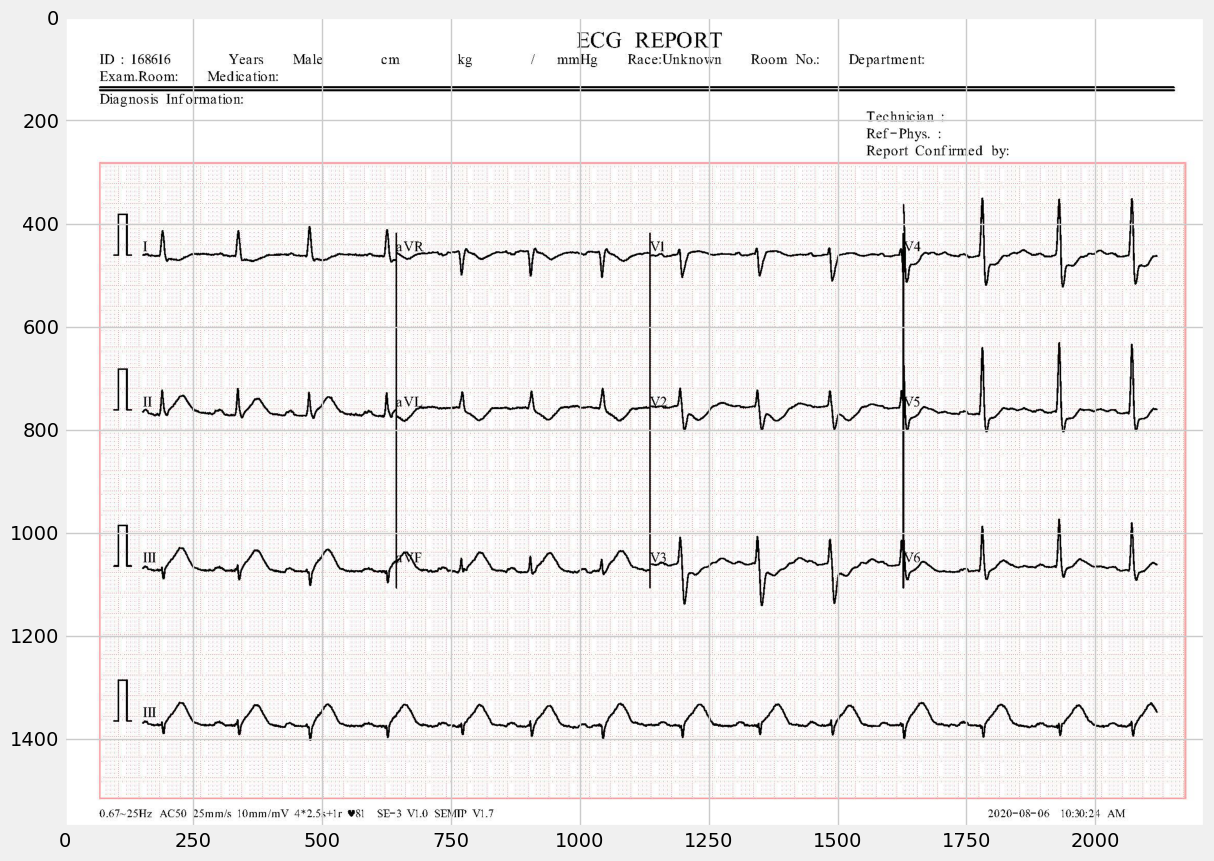

In [169]:
# MI patients data
ECG_MI_dir_ = Path('ECG_data\ECG Images of Myocardial Infarction Patients (240x12=2880)')

ECG_MI_filepaths = list(ECG_MI_dir_.glob(r'**/*.jpg'))
# Mapping the labels
MI_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], ECG_MI_filepaths))
# Paths & labels femalee eyes
ECG_MI_filepaths = pd.Series(ECG_MI_filepaths, name = 'File').astype(str)
MI_labels = pd.Series(MI_labels, name='Label')

# Concatenating...
MI_df = pd.concat([ECG_MI_filepaths, MI_labels], axis=1)
MI_df['Label'] = "MI"

figure = plt.figure(figsize=(20,10))
x = plt.imread(MI_df["File"][0])
plt.imshow(x)
plt.show()

In [170]:
MI_df['File'][0]

'ECG_data\\ECG Images of Myocardial Infarction Patients (240x12=2880)\\MI(1).jpg'

In [171]:
# HMI patients data
ECG_HMI_dir_ = Path('./ECG_data/ECG Images of Patient that have History of MI (172x12=2064)')

ECG_HMI_filepaths = list(ECG_HMI_dir_.glob(r'**/*.jpg'))
# Mapping the labels
HMI_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], ECG_HMI_filepaths))
# Paths & labels femalee eyes
ECG_HMI_filepaths = pd.Series(ECG_HMI_filepaths, name = 'File').astype(str)
HMI_labels = pd.Series(HMI_labels, name='Label')

# Concatenating...
HMI_df = pd.concat([ECG_HMI_filepaths, HMI_labels], axis=1)
HMI_df['Label'] = "HMI"

HMI_df['File'][0]

'ECG_data\\ECG Images of Patient that have History of MI (172x12=2064)\\PMI(1).jpg'

In [172]:
# AbnHB patients data
ECG_AbnHB_dir_ = Path('./ECG_data/ECG Images of Patient that have abnormal heartbeat (233x12=2796)')

ECG_AbnHB_filepaths = list(ECG_AbnHB_dir_.glob(r'**/*.jpg'))
# Mapping the labels
AbnHB_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], ECG_AbnHB_filepaths))
# Paths & labels femalee eyes
ECG_AbnHB_filepaths = pd.Series(ECG_AbnHB_filepaths, name = 'File').astype(str)
AbnHB_labels = pd.Series(AbnHB_labels, name='Label')

# Concatenating...
AbnHB_df = pd.concat([ECG_AbnHB_filepaths, AbnHB_labels], axis=1)
AbnHB_df['Label'] = "ABNORMAL"
AbnHB_df['File'][0]

'ECG_data\\ECG Images of Patient that have abnormal heartbeat (233x12=2796)\\HB(1).jpg'

In [173]:
# Normal patients data
ECG_Normal_dir_ = Path('./ECG_data/Normal Person ECG Images (284x12=3408)')

ECG_Normal_filepaths = list(ECG_Normal_dir_.glob(r'**/*.jpg'))

       
# Mapping the labels
Normal_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], ECG_Normal_filepaths))
# Paths & labels femalee eyes
ECG_Normal_filepaths = pd.Series(ECG_Normal_filepaths, name = 'File').astype(str)
Normal_labels = pd.Series(Normal_labels, name='Label')

# Concatenating...
Normal_df = pd.concat([ECG_Normal_filepaths, Normal_labels], axis=1)
Normal_df['Label'] = "NORMAL"
Normal_df["File"][0]

'ECG_data\\Normal Person ECG Images (284x12=3408)\\Normal(1).jpg'

In [174]:
# concat
df_ECG = pd.concat([MI_df, HMI_df, AbnHB_df,Normal_df],ignore_index=True)
df_ECG

,File,Label
0,ECG_data\ECG Images of Myocardial Infarction P...,MI
1,ECG_data\ECG Images of Myocardial Infarction P...,MI
2,ECG_data\ECG Images of Myocardial Infarction P...,MI
3,ECG_data\ECG Images of Myocardial Infarction P...,MI
4,ECG_data\ECG Images of Myocardial Infarction P...,MI
...,...,...
923,ECG_data\Normal Person ECG Images (284x12=3408...,NORMAL
924,ECG_data\Normal Person ECG Images (284x12=3408...,NORMAL
925,ECG_data\Normal Person ECG Images (284x12=3408...,NORMAL
926,ECG_data\Normal Person ECG Images (284x12=3408...,NORMAL


below function is used to crop the images.

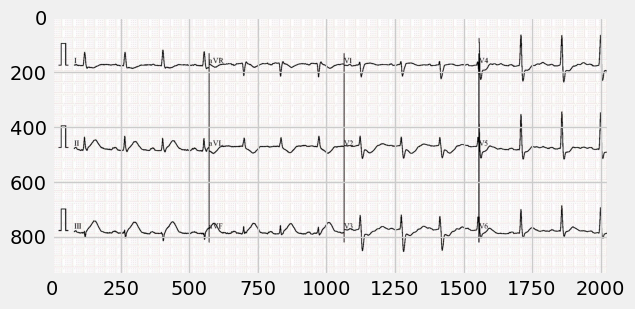

In [175]:
def crop_image(image, left = 71.5, top = 287.5, right = 2102, bottom = 1228):
    img = Image.open(image)
    cropped_img = img.crop((left, top, right, bottom))
    return cropped_img

plt.imshow(crop_image(df_ECG["File"][0]))
plt.show()

In [176]:
def remove_background(image,name):
  
    img = np.asarray(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold input image as mask
    mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]
    mask = 255 - mask

    # apply morphology to remove isolated extraneous noise. use borderconstant of black since foreground touches the edges
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # anti-alias the mask -- blur then stretch. blur alpha channel
    mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

    # linear stretch so that 127.5 goes to 0, but 255 stays 255
    mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

    result = img.copy()
    result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
    result[:, :, 3] = mask
#     cv2.imshow('gray', result)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    cv2.imwrite('./preprocessd_images/outECG/'+ str(name), result)

    result = Image.fromarray(result)
    return result

In [177]:
def get_processed_image(df, folder_name):
    image = []
    name = []
    
    for i in range(0, df.shape[0]):
        filepath = df["File"][i]
        filename = filepath.split('\\')[2]
        output = remove_background(crop_image(filepath), folder_name + str(filename))
        image.append(output)
        name.append(filename)
    
    new_dataframe = pd.DataFrame(image, columns = ['PilImage'])
    new_dataframe['filename']= name
    new_dataframe['filename'].replace({"\(":"_",'\).jpg':''}, regex=True,inplace=True)
    return new_dataframe

MI_c_bg_df = get_processed_image(MI_df,'MI_c_bg/')
HMI_c_bg_df = get_processed_image(HMI_df,'HMI_c_bg/')
Normal_c_bg_df = get_processed_image(Normal_df,'Normal_c_bg/')
AbnHB_c_bg_df = get_processed_image(AbnHB_df,'AbnHB_c_bg/')

MemoryError: 

In [13]:
MI_c_bg_df.head()

,PilImage,filename
0,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_1
1,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_10
2,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_100
3,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_101
4,<PIL.Image.Image image mode=RGBA size=2030x940...,MI_102


In [14]:
HMI_c_bg_df.head()

,PilImage,filename
0,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_1
1,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_10
2,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_100
3,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_101
4,<PIL.Image.Image image mode=RGBA size=2030x940...,PMI_102


In [15]:
Normal_c_bg_df.head()

,PilImage,filename
0,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_1
1,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_10
2,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_100
3,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_101
4,<PIL.Image.Image image mode=RGBA size=2030x940...,Normal_102


In [16]:
AbnHB_c_bg_df.head()

,PilImage,filename
0,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_1
1,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_10
2,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_100
3,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_101
4,<PIL.Image.Image image mode=RGBA size=2030x940...,HB_102


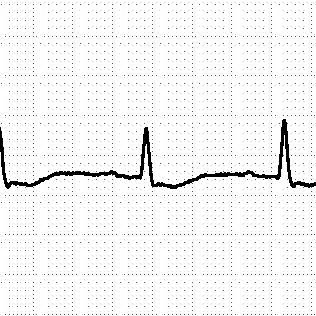

In [17]:
image=MI_c_bg_df["PilImage"][0]
width= 315
height= 315
image.crop((120.5, 0.5, width + 120.5 , 0.5 + height)).convert('L')

Below function is used to extract 12 leads from the ECG data

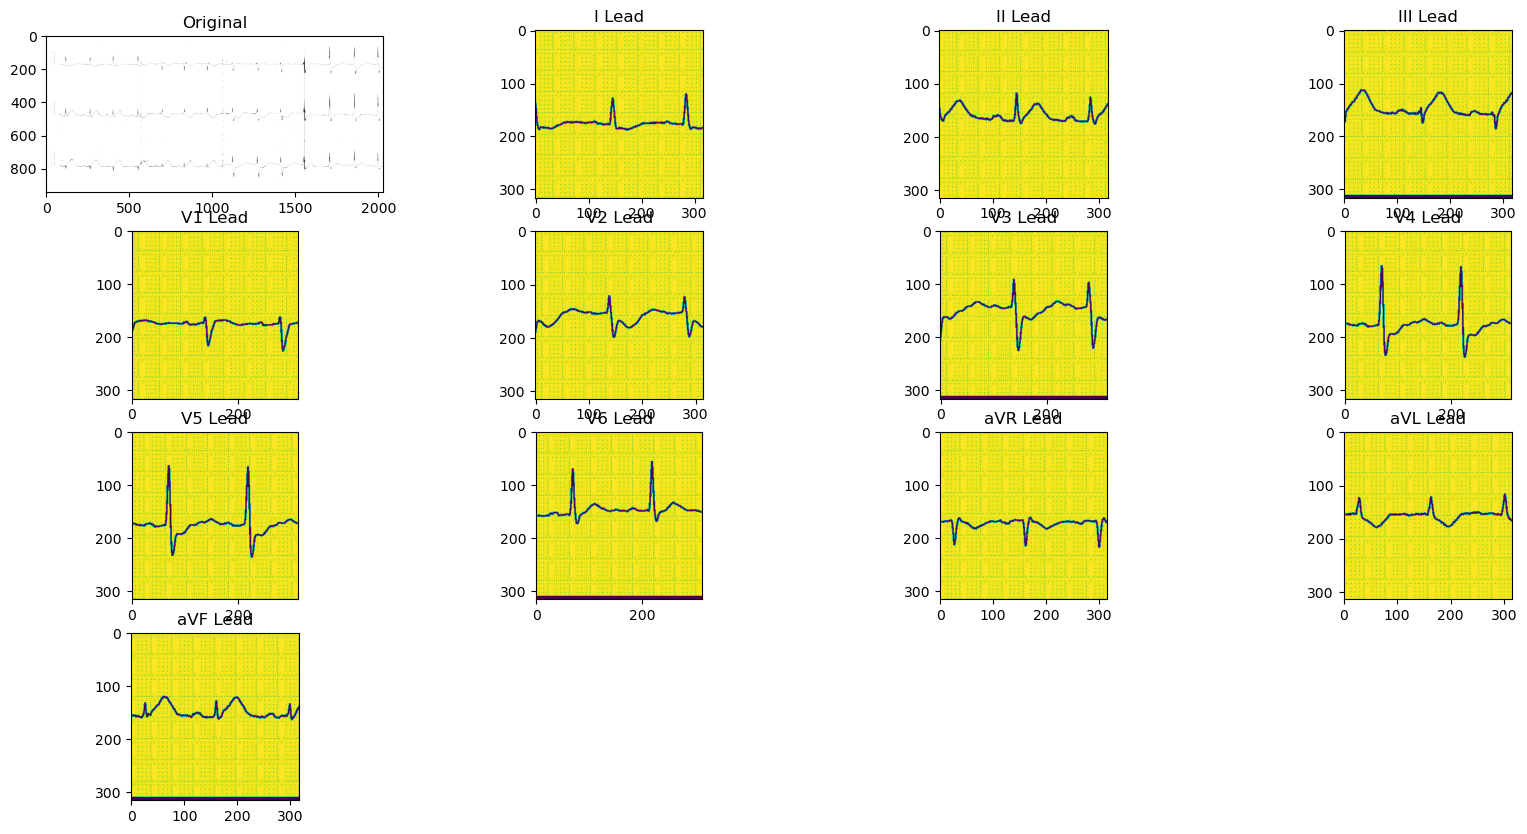

In [18]:
image=MI_c_bg_df["PilImage"][0]
width= 315
height= 315
I_img   = image.crop((120.5, 0.5, width + 120.5 , 0.5 + height)).convert('L') # Converting Images to Grayscale
II_img  = image.crop((120.5, 315.5, width + 120.5 , 315.5+ height)).convert('L')
III_img = image.crop((120.5, 630.5, width + 120.5 , 630.5+ height)).convert('L')
aVR_img = image.crop((672.5, 0.5, width + 672.5 , 0.5 + height)).convert('L')
aVL_img = image.crop((672.5, 315.5, width + 672.5 , 315.5+ height)).convert('L')
aVF_img = image.crop((672.5, 630.5, width + 672.5 , 630.5+ height)).convert('L')
V1_img  = image.crop((1133.5, 0.5, width + 1133.5 , 0.5+ height)).convert('L')
V2_img  = image.crop((1133.5, 315.5, width + 1133.5 , 315.5+ height)).convert('L')
V3_img  = image.crop((1133.5, 630.5, width + 1133.5 , 630.5+ height)).convert('L')
V4_img  = image.crop((1639.5, 0.5, width + 1639.5 , 0.5 + height)).convert('L')
V5_img  = image.crop((1639.5, 0.5, width + 1639.5 , 0.5+ height)).convert('L')
V6_img  = image.crop((1639.5, 630.5, width + 1639.5 , 630.5+ height)).convert('L')


plt.figure(figsize=(20,10))
plt.subplot(4,4,1)
plt.imshow(image)
plt.title("Original")

plt.subplot(4,4,2)
plt.imshow(I_img)
plt.title("I Lead")
  
plt.subplot(4,4,3)
plt.imshow(II_img)
plt.title("II Lead")

plt.subplot(4,4,4)
plt.imshow(III_img)
plt.title("III Lead")

plt.subplot(4,4,5)
plt.imshow(V1_img)
plt.title("V1 Lead")

plt.subplot(4,4,6)
plt.imshow(V2_img)
plt.title("V2 Lead")

plt.subplot(4,4,7)
plt.imshow(V3_img)
plt.title("V3 Lead")

plt.subplot(4,4,8)
plt.imshow(V4_img)
plt.title("V4 Lead")

plt.subplot(4,4,9)
plt.imshow(V5_img)
plt.title("V5 Lead")

plt.subplot(4,4,10)
plt.imshow(V6_img)
plt.title("V6 Lead")

plt.subplot(4,4,11)
plt.imshow(aVR_img)
plt.title("aVR Lead")

plt.subplot(4,4,12)
plt.imshow(aVL_img)
plt.title("aVL Lead")

plt.subplot(4,4,13)
plt.imshow(aVF_img)
plt.title("aVF Lead")

plt.show()
    

In [19]:
def save_12leads_segments(image,folder,name, width= 315, height= 315):

    # Segment 12 Leads 
    I_img   = image.crop((120.5, 0.5, width + 120.5 , 0.5 + height)).convert('L') # Converting Images to Grayscale
    II_img  = image.crop((120.5, 315.5, width + 120.5 , 315.5+ height)).convert('L')
    III_img = image.crop((120.5, 630.5, width + 120.5 , 630.5+ height)).convert('L')
    aVR_img = image.crop((672.5, 0.5, width + 672.5 , 0.5 + height)).convert('L')
    aVL_img = image.crop((672.5, 315.5, width + 672.5 , 315.5+ height)).convert('L')
    aVF_img = image.crop((672.5, 630.5, width + 672.5 , 630.5+ height)).convert('L')
    V1_img  = image.crop((1133.5, 0.5, width + 1133.5 , 0.5+ height)).convert('L')
    V2_img  = image.crop((1133.5, 315.5, width + 1133.5 , 315.5+ height)).convert('L')
    V3_img  = image.crop((1133.5, 630.5, width + 1133.5 , 630.5+ height)).convert('L')
    V4_img  = image.crop((1639.5, 0.5, width + 1639.5 , 0.5 + height)).convert('L')
    V5_img  = image.crop((1639.5, 0.5, width + 1639.5 , 0.5+ height)).convert('L')
    V6_img  = image.crop((1639.5, 630.5, width + 1639.5 , 630.5+ height)).convert('L')
    
    
    # Negative leads I,II,III, aVR,aVL,aVF
    
    I_neg_img   = Image.fromarray(cv2.flip(np.asarray(I_img),0)) # Vertical Flip
    II_neg_img  = Image.fromarray(cv2.flip(np.asarray(II_img),0)) # Vertical Flip
    III_neg_img = Image.fromarray(cv2.flip(np.asarray(III_img),0)) # Vertical Flip
    aVR_neg_img = Image.fromarray(cv2.flip(np.asarray(aVR_img),0)) # Vertical Flip
    aVL_neg_img = Image.fromarray(cv2.flip(np.asarray(aVL_img),0)) # Vertical Flip
    aVF_neg_img = Image.fromarray(cv2.flip(np.asarray(aVL_img),0)) # Vertical Flip
    
   


    I_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/I/')+ str(name)+str('.png'))   
    I_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/I_Neg/')+ str(name)+str('.png'))
    II_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/II/')+ str(name)+str('.png'))
    II_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/II_Neg/')+ str(name)+str('.png'))
    III_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/III/')+ str(name)+str('.png'))
    III_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/III_Neg/')+ str(name)+str('.png'))
    aVR_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVR/')+ str(name)+str('.png'))
    aVR_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVR_Neg/')+ str(name)+str('.png'))
    aVL_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVL/')+ str(name)+str('.png'))
    aVL_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVL_Neg/')+ str(name)+str('.png'))
    aVF_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVF/')+ str(name)+str('.png'))
    aVF_neg_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/aVF_Neg/')+ str(name)+str('.png'))
    V1_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V1/')+ str(name)+str('.png'))
    V2_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V2/')+ str(name)+str('.png'))
    V3_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V3/')+ str(name)+str('.png'))
    V4_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V4/')+ str(name)+str('.png'))
    V5_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V5/')+ str(name)+str('.png'))
    V6_img.save('./preprocessd_images/ECG_leads/'+str(folder)+str('/V6/')+ str(name)+str('.png'))


Below code to save preprocess data in /preprocessd_images/ECG_leads/
create folder /preprocessd_images/ECG_leads/ (manually)

then 12 leads of Each classes will be saved from below code automatically
HMI, MI, AbnHB, Normal 
each folder contain leads folder


In [28]:
# Iterate through MI_c_bg_df DataFrame and save images to 'MI' folder
for i in range(0, MI_c_bg_df.shape[0]):
    save_12leads_segments(image=MI_c_bg_df["PilImage"][i], folder='MI', name=str(MI_c_bg_df["filename"][i]), width, height)

# Iterate through HMI_c_bg_df DataFrame and save images to 'HMI' folder
for i in range(0, HMI_c_bg_df.shape[0]):
    save_12leads_segments(image=HMI_c_bg_df["PilImage"][i], folder='HMI', name=str(HMI_c_bg_df["filename"][i]), width, height)

# Iterate through AbnHB_c_bg_df DataFrame and save images to 'AbnHB' folder
for i in range(0, AbnHB_c_bg_df.shape[0]):
    save_12leads_segments(image=AbnHB_c_bg_df["PilImage"][i], folder='AbnHB', name=str(AbnHB_c_bg_df["filename"][i]), width, height)

# Iterate through Normal_c_bg_df DataFrame and save images to 'Normal' folder
for i in range(0, Normal_c_bg_df.shape[0]):
    save_12leads_segments(image=Normal_c_bg_df["PilImage"][i], folder='Normal', name=str(Normal_c_bg_df["filename"][i]), width, height)


SyntaxError: positional argument follows keyword argument (3128674078.py, line 3)

In [ ]:
import os
from PIL import Image

def save_12leads_segments(image, folder, name, width, height):
    # ... (your existing code)

    # Create the directory for the positive images if it doesn't exist
    positive_folder_path = f'./preprocessd_images/ECG_leads/{folder}/I/'
    os.makedirs(positive_folder_path, exist_ok=True)

    # Create the directory for the negative images if it doesn't exist
    negative_folder_path = f'./preprocessd_images/ECG_leads/{folder}/I_Neg/'
    os.makedirs(negative_folder_path, exist_ok=True)

    # Assuming 'I_neg_img' is defined and assigned a value before this point
    # Save the positive and negative images
    I_img.save(os.path.join(positive_folder_path, f'{name}.png'))
    I_neg_img.save(os.path.join(negative_folder_path, f'{name}.png'))

# Call the function with appropriate parameters
save_12leads_segments(image, 'MI', 'MI_1', width, height)


NameError: name 'I_neg_img' is not defined

In [ ]:
import fnmatch
fnames = []
for path, dirs, files in os.walk(os.path.abspath(r"./preprocessd_images/ECG_leads/AbnHB/aVF/")):
    for filename in fnmatch.filter(files, "*.png"):
        #print(filename)
        fnames.append(filename)
print(len(fnames))

233


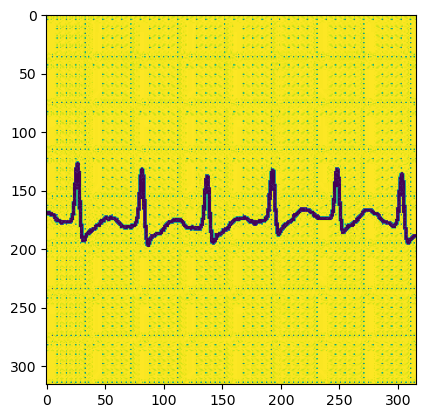

In [20]:
x = plt.imread(r"./preprocessd_images/ECG_leads/AbnHB/I/HB_31.png")
plt.imshow(x)

In [21]:
def get_12leads_to_df(root_folder):
    filepaths = []
    filenames = []
    folders = [os.path.join(root_folder, x) for x in ('I', 'I_Neg','II', 'II_Neg','III', 'III_Neg','aVR', 'aVR_Neg','aVL', 'aVL_Neg','aVF', 'aVF_Neg','V1','V2','V3','V4','V5','V6' )]
    for folder in folders:
        for filename in os.listdir(folder):
            if filename.endswith(".png"):
                fp =os.path.join(folder, filename)
                filepaths.append(fp)
                filenames.append(filename)
    df = pd.DataFrame(filenames, columns = ['filename'])
    df['filepaths'] = filepaths
    df['label'] = root_folder.split('/')[-2]
    return df

In [22]:
MI = get_12leads_to_df('./preprocessd_images/ECG_leads/MI/')
HMI  = get_12leads_to_df('./preprocessd_images/ECG_leads/HMI/')
AbnHB  = get_12leads_to_df('./preprocessd_images/ECG_leads/AbnHB/')
Normal =  get_12leads_to_df('./preprocessd_images/ECG_leads/Normal/')

In [94]:
HMI

,filename,filepaths,label
0,PMI_1.png,./preprocessd_images/ECG_leads/HMI/I\PMI_1.png,HMI
1,PMI_10.png,./preprocessd_images/ECG_leads/HMI/I\PMI_10.png,HMI
2,PMI_100.png,./preprocessd_images/ECG_leads/HMI/I\PMI_100.png,HMI
3,PMI_101.png,./preprocessd_images/ECG_leads/HMI/I\PMI_101.png,HMI
4,PMI_102.png,./preprocessd_images/ECG_leads/HMI/I\PMI_102.png,HMI
...,...,...,...
3091,PMI_95.png,./preprocessd_images/ECG_leads/HMI/V6\PMI_95.png,HMI
3092,PMI_96.png,./preprocessd_images/ECG_leads/HMI/V6\PMI_96.png,HMI
3093,PMI_97.png,./preprocessd_images/ECG_leads/HMI/V6\PMI_97.png,HMI
3094,PMI_98.png,./preprocessd_images/ECG_leads/HMI/V6\PMI_98.png,HMI


In [117]:
df

,filename,filepaths,label
0,MI_1.png,./preprocessd_images/ECG_leads/MI/I\MI_1.png,MI
1,MI_10.png,./preprocessd_images/ECG_leads/MI/I\MI_10.png,MI
2,MI_100.png,./preprocessd_images/ECG_leads/MI/I\MI_100.png,MI
3,MI_101.png,./preprocessd_images/ECG_leads/MI/I\MI_101.png,MI
4,MI_102.png,./preprocessd_images/ECG_leads/MI/I\MI_102.png,MI
...,...,...,...
16699,Normal_95.png,./preprocessd_images/ECG_leads/Normal/V6\Norma...,Normal
16700,Normal_96.png,./preprocessd_images/ECG_leads/Normal/V6\Norma...,Normal
16701,Normal_97.png,./preprocessd_images/ECG_leads/Normal/V6\Norma...,Normal
16702,Normal_98.png,./preprocessd_images/ECG_leads/Normal/V6\Norma...,Normal


In [102]:
df = pd.concat([MI, HMI, AbnHB,Normal],ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16704 entries, 0 to 16703
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   16704 non-null  object
 1   filepaths  16704 non-null  object
 2   label      16704 non-null  object
dtypes: object(3)
memory usage: 391.6+ KB


In [103]:
df = pd.concat([MI, HMI, AbnHB,Normal],ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16704 entries, 0 to 16703
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   16704 non-null  object
 1   filepaths  16704 non-null  object
 2   label      16704 non-null  object
dtypes: object(3)
memory usage: 391.6+ KB


In [104]:
# select random 3000 samples from each class
df1 = df.copy()
df1_1 = df1[df1['label'] == 'MI'].sample(3000)
df1_2 = df1[df1['label'] == 'HMI'].sample(3000)
df1_3 = df1[df1['label'] == 'AbnHB'].sample(3000)
df1_4 = df1[df1['label'] == 'Normal'].sample(3000)
df_3K = pd.concat([df1_1, df1_2, df1_3,df1_4],ignore_index=True)

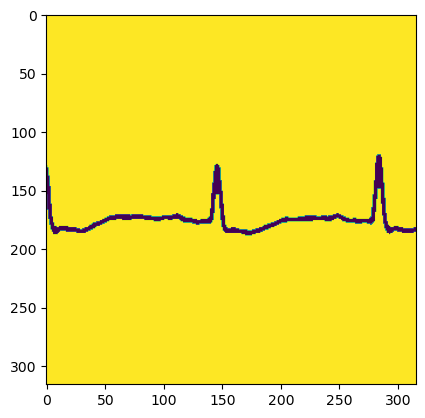

In [27]:
def salt(img, n):
    for k in range(n):
        i = int(np.random.random() * img.shape[1])
        j = int(np.random.random() * img.shape[0])
        if img.ndim == 2:
            img[j,i] = 255
        elif img.ndim == 3:
            img[j,i,0]= 255
            img[j,i,1]= 255
            img[j,i,2]= 255
        return img
    
def bg_remov(image):
    result = salt(image, 10)
    median = cv2.medianBlur(result,5)
    gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 85, 255, cv2.THRESH_BINARY)
    return blackAndWhiteImage

img_array = cv2.imread(df['filepaths'][0])   # converting the image to gray scale
img_array = bg_remov(img_array)
plt.imshow(img_array)

In [105]:
le = LabelEncoder()
df_3K["label"] = le.fit_transform(df_3K["label"])
df_3K

,filename,filepaths,label
0,MI_209.png,./preprocessd_images/ECG_leads/MI/aVL_Neg\MI_2...,2
1,MI_124.png,./preprocessd_images/ECG_leads/MI/aVR\MI_124.png,2
2,MI_191.png,./preprocessd_images/ECG_leads/MI/III\MI_191.png,2
3,MI_35.png,./preprocessd_images/ECG_leads/MI/V3\MI_35.png,2
4,MI_20.png,./preprocessd_images/ECG_leads/MI/aVL\MI_20.png,2
...,...,...,...
11995,Normal_66.png,./preprocessd_images/ECG_leads/Normal/V6\Norma...,3
11996,Normal_103.png,./preprocessd_images/ECG_leads/Normal/aVR\Norm...,3
11997,Normal_5.png,./preprocessd_images/ECG_leads/Normal/aVL_Neg\...,3
11998,Normal_161.png,./preprocessd_images/ECG_leads/Normal/V2\Norma...,3


In [74]:
class_name_to_index = {
    "MI": 0,
    "HMI": 1,
    "AbnHB": 2,
    "Normal": 3
}


In [75]:
df_3K['class_index'] = df_3K['label'].map(class_name_to_index)


In [106]:
df_3K

,filename,filepaths,label
0,MI_209.png,./preprocessd_images/ECG_leads/MI/aVL_Neg\MI_2...,2
1,MI_124.png,./preprocessd_images/ECG_leads/MI/aVR\MI_124.png,2
2,MI_191.png,./preprocessd_images/ECG_leads/MI/III\MI_191.png,2
3,MI_35.png,./preprocessd_images/ECG_leads/MI/V3\MI_35.png,2
4,MI_20.png,./preprocessd_images/ECG_leads/MI/aVL\MI_20.png,2
...,...,...,...
11995,Normal_66.png,./preprocessd_images/ECG_leads/Normal/V6\Norma...,3
11996,Normal_103.png,./preprocessd_images/ECG_leads/Normal/aVR\Norm...,3
11997,Normal_5.png,./preprocessd_images/ECG_leads/Normal/aVL_Neg\...,3
11998,Normal_161.png,./preprocessd_images/ECG_leads/Normal/V2\Norma...,3


In [135]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Get the unique class labels and their corresponding class numbers
# class_labels = le.classes_
class_numbers = le.fit_transform(df_3K['label'])

# Create a dictionary to map class numbers to class labels
# class_mapping = {class_number: class_label for class_number, class_label in zip(class_numbers, class_labels)}

# # Print the class mapping
# print(class_mapping)


In [136]:
le.classes_

array([0, 1, 2, 3])

In [ ]:
AbnHB', 'HMI', 'MI', 'Normal'    df

In [ ]:
array([0=AbnHB, 1= HMI, 2=MI, 3==Normal])     df_3k

In [116]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit the label encoder to your class labels
le.fit(df_3K['label'])


array([0, 1, 2, 3])

In [137]:
# Display a sample of rows from the DataFrame with class labels
sample_df = df_3K.sample(10)  # You can adjust the number of samples as needed
print(sample_df)


             filename                                          filepaths  \
208         MI_26.png     ./preprocessd_images/ECG_leads/MI/V5\MI_26.png   
5805      PMI_140.png  ./preprocessd_images/ECG_leads/HMI/aVR_Neg\PMI...   
4038       PMI_93.png   ./preprocessd_images/ECG_leads/HMI/V3\PMI_93.png   
1926       MI_135.png   ./preprocessd_images/ECG_leads/MI/aVF\MI_135.png   
6756       HB_167.png  ./preprocessd_images/ECG_leads/AbnHB/II_Neg\HB...   
2408       MI_177.png     ./preprocessd_images/ECG_leads/MI/I\MI_177.png   
6390       HB_171.png  ./preprocessd_images/ECG_leads/AbnHB/V6\HB_171...   
1299        MI_71.png      ./preprocessd_images/ECG_leads/MI/I\MI_71.png   
5874       PMI_31.png   ./preprocessd_images/ECG_leads/HMI/V3\PMI_31.png   
11659  Normal_165.png  ./preprocessd_images/ECG_leads/Normal/aVL\Norm...   

       label class_name  
208        2      AbnHB  
5805       1        HMI  
4038       1        HMI  
1926       2      AbnHB  
6756       0         MI  
2408   

In [138]:
# Create a mapping of class numbers to class labels
class_mapping = {0: 'MI', 1: 'HMI', 2: 'AbnHB', 3: 'Normal'}

# Add a new column to the DataFrame with class names
df_3K['class_name'] = df_3K['label'].map(class_mapping)

# Display a sample of rows from the DataFrame with class labels
sample_df = df_3K.sample(10)  # You can adjust the number of samples as needed
print(sample_df[['filename', 'label', 'class_name']])


            filename  label class_name
4720     PMI_123.png      1        HMI
10651  Normal_54.png      3     Normal
3776      PMI_72.png      1        HMI
7852      HB_183.png      0         MI
6182      HB_226.png      0         MI
4927      PMI_28.png      1        HMI
1192      MI_122.png      2      AbnHB
1742       MI_56.png      2      AbnHB
5183      PMI_75.png      1        HMI
6220      HB_169.png      0         MI


In [139]:
class_distribution = df_3K['label'].value_counts()
print(class_distribution)


2    3000
1    3000
0    3000
3    3000
Name: label, dtype: int64


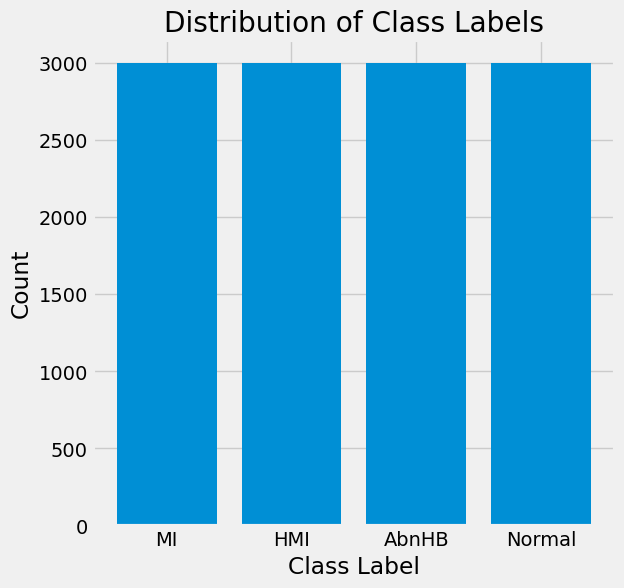

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(list(class_mapping.keys()), class_mapping.values())
plt.title('Distribution of Class Labels')
plt.show()


In [143]:
for label, class_name in class_mapping.items():
    sample_rows = df_3K[df_3K['label'] == label].sample(5)  # Adjust the number of samples as needed
    print(f"Class {label} ({class_name}):")
    print(sample_rows[['filename', 'label', 'class_name']])


Class 0 (MI):
        filename  label class_name
6366   HB_76.png      0         MI
7970  HB_125.png      0         MI
6656   HB_75.png      0         MI
8201    HB_7.png      0         MI
8478  HB_127.png      0         MI
Class 1 (HMI):
         filename  label class_name
4934   PMI_42.png      1        HMI
4965  PMI_120.png      1        HMI
4025  PMI_129.png      1        HMI
5571   PMI_27.png      1        HMI
3797  PMI_166.png      1        HMI
Class 2 (AbnHB):
        filename  label class_name
382   MI_149.png      2      AbnHB
2262  MI_229.png      2      AbnHB
426   MI_128.png      2      AbnHB
1960  MI_151.png      2      AbnHB
1406  MI_142.png      2      AbnHB
Class 3 (Normal):
             filename  label class_name
10062   Normal_93.png      3     Normal
10678   Normal_36.png      3     Normal
11317  Normal_152.png      3     Normal
11136    Normal_5.png      3     Normal
9327   Normal_255.png      3     Normal


In [29]:
df["label"].value_counts()

Normal    5112
MI        4302
AbnHB     4194
HMI       3096
Name: label, dtype: int64

In [30]:
x = plt.imread(df_3K['filepaths'][0])
x.shape

(314, 316)

In [31]:
data = []   
image_size = 100
for i in range(len(df_3K)):
    img_array = cv2.imread(df_3K['filepaths'][i])  
    img_array = bg_remov(img_array)
    new_img_array = cv2.resize(img_array, (image_size, image_size)) 
    data.append([new_img_array, df_3K['label'][i]])

In [41]:
type(new_img_array)

numpy.ndarray

In [32]:
np.random.shuffle(data)
x = []
y = []
for i in data:
    x.append(i[0])
    y.append(i[1])
x = np.array(x).reshape(-1, 100, 100, 1)
y = np.array(y)

In [43]:
type(x)
type(y)

numpy.ndarray

In [73]:
x_indices = train_datagen.class_indices
class_names = list(x_indices.keys())
print(class_names)


NameError: name 'train_datagen' is not defined

In [44]:
X_train, X_val, y_train, y_val=train_test_split(x,y, train_size=0.8, shuffle=True, random_state=42)
# X_val, X_test, y_val, y_test=train_test_split(X_dum, y_dum, train_size= 0.5, shuffle=True, random_state=42)

X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
# X_test = X_test.astype('float32')/255

X_train.shape, X_val.shape
# X_test.shape

((9600, 100, 100, 1), (2400, 100, 100, 1))

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.3, random_state = 42)
# X_train = X_train.astype('float32')/255
# X_val = X_val.astype('float32')/255
# X_train.shape, X_val.shape

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D, MaxPool2D,BatchNormalization, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

# from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

C:\Users\saqla\AppData\Local\Temp\ipykernel_6808\3909733348.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', input_shape = (100, 100, 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
])

model.compile(optimizer ='adam',
              loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy']
             )
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 33856)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [47]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# checkpoint = ModelCheckpoint('ECGdetetcionModel.h5',
#                              monitor='val_loss',
#                              mode='min',
#                              save_best_only=True,
#                              verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

allChecks = [earlystop, reduce_lr]

In [48]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50,  callbacks=allChecks,validation_data=(X_val, y_val))

Epoch 1/50
75/75 [==============================] - 60s 783ms/step - loss: 1.4304 - accuracy: 0.2646 - val_loss: 1.3565 - val_accuracy: 0.3579 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 66s 884ms/step - loss: 1.2895 - accuracy: 0.3767 - val_loss: 1.2560 - val_accuracy: 0.4058 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 60s 803ms/step - loss: 1.1948 - accuracy: 0.4508 - val_loss: 1.1714 - val_accuracy: 0.4879 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 62s 824ms/step - loss: 1.0829 - accuracy: 0.5342 - val_loss: 1.0815 - val_accuracy: 0.5283 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 63s 848ms/step - loss: 0.9500 - accuracy: 0.6054 - val_loss: 1.0121 - val_accuracy: 0.5729 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 60s 798ms/step - loss: 0.8334 - accuracy: 0.6661 - val_loss: 0.8991 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/50
75/75 [==============================] - 57s 760ms/st

In [49]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

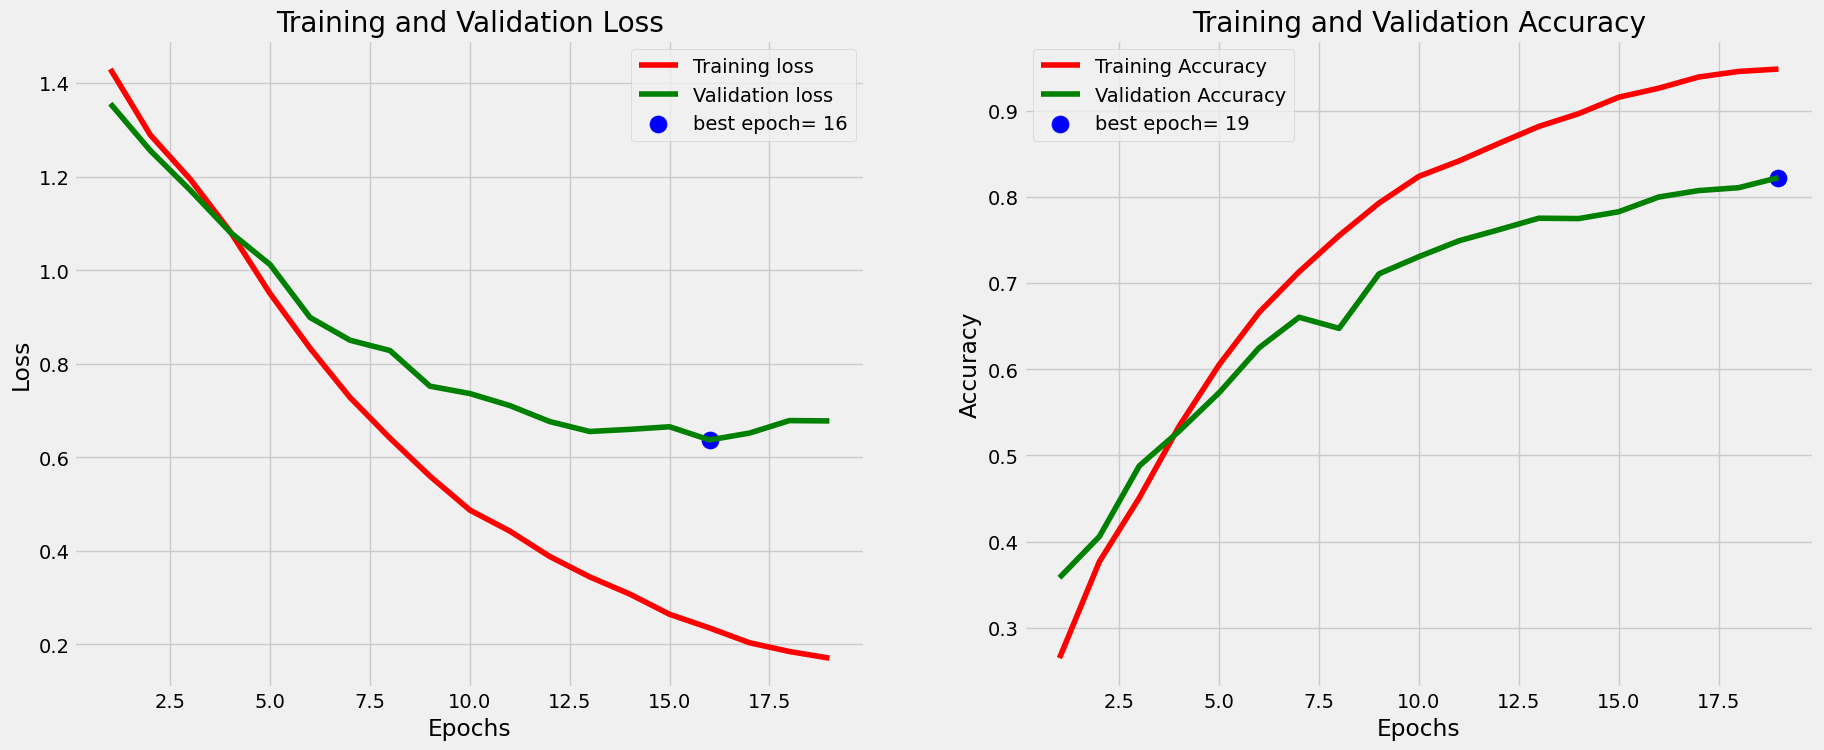

In [51]:
tr_plot(history,0)

In [166]:
score = model.evaluate(X_val, y_val)
print("test loss ", score[0])
print("test accuracy ", score[1])

75/75 [==============================] - 6s 74ms/step - loss: 0.6373 - accuracy: 0.8000
test loss  0.637308657169342
test accuracy  0.800000011920929


In [53]:
prediction = model.predict(X_test)
prediction

38/38 [==============================] - 3s 62ms/step


array([[1.85933299e-02, 9.60014701e-01, 3.38126426e-07, 2.13916302e-02],
       [5.56016294e-03, 9.91412818e-01, 3.88374086e-04, 2.63856957e-03],
       [5.14206700e-02, 1.20049186e-01, 8.57320577e-02, 7.42798030e-01],
       ...,
       [8.67725313e-01, 7.36096725e-02, 6.37236144e-03, 5.22925891e-02],
       [9.92599189e-01, 1.72006735e-03, 1.14187378e-05, 5.66920312e-03],
       [5.88233508e-02, 1.60000414e-01, 1.49474596e-04, 7.81026781e-01]],
      dtype=float32)

In [54]:
predictions = []
for i in prediction:
    predictions.append(int(np.argmax(i)))
#     print(int(np.argmax(prediction[i])), y_test[i])
#     print(le.inverse_transform([np.argmax(prediction[i])]))
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       307
           1       0.79      0.73      0.76       314
           2       0.95      0.96      0.96       276
           3       0.71      0.76      0.73       303

    accuracy                           0.80      1200
   macro avg       0.81      0.81      0.81      1200
weighted avg       0.80      0.80      0.80      1200



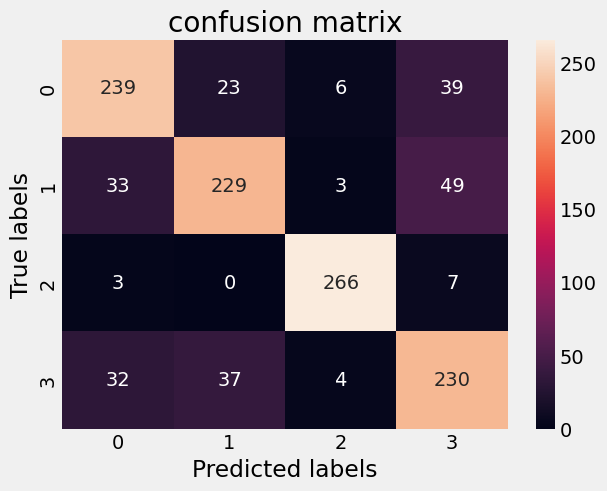

In [55]:
cm = confusion_matrix( y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g');
plt.title("confusion matrix")
plt.xlabel('Predicted labels')
plt.ylabel('True labels'); 

class_mapping = {0: 'MI', 1: 'HMI', 2: 'AbnHB', 3: 'Normal'}

In [144]:

# save trained model
model.save('CNN_model_1.h5')


In [145]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('CNN_model_1.h5')


In [65]:
import cv2

# Load your input image as grayscale
input_image = cv2.imread('C:\\Users\\saqla\\Desktop\\Heart-diesease-detection-using-ECG-images-main\\ECG_data\\Normal Person ECG Images (284x12=3408)\\Normal(1).jpg', cv2.IMREAD_GRAYSCALE)

    # Convert the grayscale image to a 3-channel image (duplicate the single channel)
input_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)

    # Now you can use input_image with OpenCV functions that expect 3 channels

    # Example: Resize the image
resized_image = cv2.resize(input_image, (100, 100))



In [165]:
import cv2
import numpy as np
import tensorflow as tf

# Load the model (assuming you have already trained and saved the model)
model = tf.keras.models.load_model('CNN_model_1.h5')

# Load your input image
input_image = cv2.imread('C:\\Users\\saqla\\Desktop\\Heart-diesease-detection-using-ECG-images-main\\ECG_data\\ECG Images of Patient that have abnormal heartbeat (233x12=2796)\\HB(45).jpg', cv2.IMREAD_GRAYSCALE)
input_image = cv2.resize(input_image, (100, 100))  # Resize to match the model's input shape
input_image = input_image.astype('float32') / 255  # Normalize the pixel values
input_image = input_image.reshape(1, 100, 100, 1)  # Reshape for model input

# Make predictions
predictions = model.predict(input_image)
# class_mapping = {0: 'MI', 1: 'HMI', 2: 'AbnHB', 3: 'Normal'}
# Interpret the predictions
class_names = ['MI', 'HMI', 'AbnHB', 'Normal']  # Replace with your actual class names
predicted_class = np.argmax(predictions, axis=-1)
predicted_class_name = class_names[predicted_class[0]]

# Print the predicted class and confidence
print(f'Predicted Class: {predicted_class_name}')
print(f'Confidence: {predictions[0][predicted_class[0]] * 100:.2f}%')


1/1 [==============================] - 0s 163ms/step
Predicted Class: MI
Confidence: 92.93%
